In [6]:
#----------------------------------------------------------------------#
# Slow pion dataset creation script

# Data
import numpy as np
import awkward as ak
import pandas as pd
import dask
import dask.dataframe as dd

import torch_geometric as tg

# I/O
import uproot as ur
import hipopy.hipopy as hp # <--- Package for reading in the hipo files

# Plotting
import matplotlib.pyplot as plt

# Physics
from particle import PDGID

# Miscellaneous
import os
import sys #NOTE: ADDED
import tqdm

# ML Imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split


In [7]:
#----------------------------------------------------------------------#
# HIPO bank reading and linking functions

def get_bank_keys(bank_name,all_keys,separator='_'):
    """
    :description: Get list of the keys for given bank name from a list of all batch keys.
    
    :param: bank_name
    :param: all_keys
    :param: separator='_'
    
    :return: bank_keys
    """
    bank_keys = []
    for key in all_keys:
        if key.startswith(bank_name+separator):
            bank_keys.append(key)
    return bank_keys
        
def get_event_table(bank_keys,event_num,batch,dtype=float):
    """
    :description: Get a bank event table as a numpy array of shape (number of columns, number of rows).
    
    :param: bank_keys
    :param: event_num
    :param: batch
    :param: dtype=float
    
    :return: bank_table
    """
    bank_table = []
    bank_table = np.moveaxis(np.array([batch[key][event_num] for key in bank_keys], dtype=dtype),[0,1],[1,0])
    return bank_table

def get_link_indices(event_table_rec_particle,event_table,pindex_idx=1):
    """
    :description: Get index pairs linking entries in a bank back to entries in the 'REC::Particle' bank.
    
    :param: event_table_rec_particle
    :param: event_table
    :param: pindex_idx=1
    
    :return: link_indices
    """
    
    link_indices = []
    nrec = np.shape(event_table_rec_particle)[0]
    for rec_particle_idx in range(0,nrec):
        for event_table_idx, el in enumerate(event_table[:,pindex_idx]):
            if el==rec_particle_idx:
                link_indices.append([rec_particle_idx,event_table_idx])
    return np.array(link_indices,dtype=int) #NOTE: link_indices = [(event_table_idx,rec_particle_idx)]

def get_parent_indices(mc_event_table,index_idx=0,parent_idx=4,daughter_idx=5):
    """
    TODO
    """
    for mc_event_table_idx, index in enumerate(mc_event_table[:,index_idx]):
        pass
    pass

def get_match_indices(
    rec_event_table,
    mc_event_table,
    rec_px_idx             = 1,
    rec_py_idx             = 2,
    rec_pz_idx             = 3,
    rec_ch_idx             = 8,
    mc_px_idx              = 6,
    mc_py_idx              = 7,
    mc_pz_idx              = 8,
    mc_pid_idx             = 3,
    mc_daughter_idx        = 5,
    match_charge           = True,
    require_no_mc_daughter = True,
    enforce_uniqueness     = True,
    ):
    """
    :description: Get index pairs matching 
    
    :param: rec_event_table
    :param: mc_event_table
    :param: rec_px_idx             = 1,
    :param: rec_py_idx             = 2,
    :param: rec_pz_idx             = 3,
    :param: rec_ch_idx             = 8,
    :param: mc_px_idx              = 6,
    :param: mc_py_idx              = 7,
    :param: mc_pz_idx              = 8,
    :param: mc_pid_idx             = 3,
    :param: mc_daughter_idx        = 5,
    :param: match_charge           = True,
    :param: require_no_mc_daughter = True,
    :param: enforce_uniqueness     = True,
    
    :return: match_indices
    """
    
    # Set minimum
    rec_final_state_min_idx = 1
    mc_final_state_min_idx  = 3 #NOTE: MC::Lund bank is structured [e, p, q, e', all the other final state particles...]
    
    # Initialize index map
    match_indices    = -np.ones((rec_event_table.shape[0],2),dtype=float)
    match_indices[0] = [0,3] #NOTE: Always match first entry in REC::Particle to scattered electron in MC::Lund.

    # Get REC::Particle info
    rec_px    = rec_event_table[:,rec_px_idx]
    rec_py    = rec_event_table[:,rec_py_idx]
    rec_pz    = rec_event_table[:,rec_pz_idx]
    rec_pT    = np.sqrt(np.square(rec_event_table[:,rec_px_idx])+np.square(rec_event_table[:,rec_py_idx]))
    rec_p     = np.sqrt(np.square(rec_event_table[:,rec_px_idx])+np.square(rec_event_table[:,rec_py_idx])+np.square(rec_event_table[:,rec_pz_idx]))
    rec_theta = np.array(rec_pz)
    rec_theta = np.arctan(rec_pT,rec_theta)
    rec_phi   = np.arctan2(rec_py,rec_px)
    
    # Get MC::Lund info
    mc_px    = mc_event_table[:,mc_px_idx]
    mc_py    = mc_event_table[:,mc_py_idx]
    mc_pz    = mc_event_table[:,mc_pz_idx]
    mc_pT    = np.sqrt(np.square(mc_event_table[:,mc_px_idx])+np.square(mc_event_table[:,mc_py_idx]))
    mc_p     = np.sqrt(np.square(mc_event_table[:,mc_px_idx])+np.square(mc_event_table[:,mc_py_idx])+np.square(mc_event_table[:,mc_pz_idx]))
    mc_theta = np.array(mc_pz)
    mc_theta = np.arctan(mc_pT,mc_theta)
    mc_phi   = np.arctan2(mc_py,mc_px)

    # Loop rec particles
    for rec_idx, rec_part in enumerate(rec_event_table):
        
        # Start with final state particles past scattered electron
        if rec_idx<rec_final_state_min_idx: continue
        
        # Get REC::Particle charge
        rec_ch = rec_event_table[rec_idx,rec_ch_idx]
        
        # Loop mc particles
        mc_match_idx = -1
        min_domega   = 9999
        for mc_idx, mc_part in enumerate(mc_event_table):
            
            # Start with final state particles past scattered electron
            if mc_idx<mc_final_state_min_idx:
                continue
            
            # Enforce unique matching
            if enforce_uniqueness and mc_idx in match_indices[:,1]:
                continue
            
            # Match charge and require that the MC particle be final state (no daughters)
            if match_charge and rec_ch!=PDGID(mc_event_table[mc_idx,mc_pid_idx]).charge:
                continue
            if require_no_mc_daughter and mc_event_table[mc_idx,mc_daughter_idx]!=0:
                continue
                
            # Get angular and momentum differences
            dp     = np.abs(rec_p[rec_idx]     - mc_p[mc_idx])
            dtheta = np.abs(rec_theta[rec_idx] - mc_theta[mc_idx])
            dphi   = np.abs(rec_phi[rec_idx]   - mc_phi[mc_idx]) if np.abs(rec_phi[rec_idx] - mc_phi[mc_idx])<np.pi else 2*np.pi-np.abs(rec_phi[rec_idx] - mc_phi[mc_idx])
            domega = dp**2 + dtheta**2 + dphi**2
            
            # Reset angular, momentum minimum difference
            if domega<min_domega:
                min_domega   = domega
                mc_match_idx = mc_idx
                
        # Append matched index pair
        match_indices[rec_idx] = [rec_idx,mc_match_idx]
        
    return np.array(match_indices,dtype=int) #NOTE: IMPORTANT!

def get_info(base_indices,link_indices,bank_entry_indices,bank_event_table):
    """
    :description: Get selected entry info from other banks linked to REC::Particle.
    
    :param: base_indices
    :param: link_indices #NOTE: if None assume bank is REC::Particle and use identity map
    :param: bank_entry_indices
    :param: bank_event_table
    
    :return: bank_info as awkward.Array
    """
    if link_indices is None:
        bank_info = []
        for base_idx in base_indices:
            base_info = bank_event_table[base_idx,bank_entry_indices]
            bank_info.append([base_info])
            
        return ak.Array(bank_info)
            
    bank_info = []
    for base_idx in base_indices:
        base_info = []
        for rec_particle_idx, link_idx in link_indices:
            if rec_particle_idx==base_idx:
                base_info.append(bank_event_table[link_idx,bank_entry_indices]) #NOTE: INDICES HAVE TO BE INTEGERS...COULD ADD CHECK...
        if len(base_info)==0: #NOTE: Address case that no matches exist between banks
            base_info.append(np.zeros((len(bank_entry_indices),)))
        bank_info.append(base_info)
    
    return ak.Array(bank_info)

def get_truth_info(base_indices,match_indices,truth_entry_indices,mc_event_table):
    """
    :description: Get selected entry info from other banks linked to REC::Particle.
    
    :param: base_indices
    :param: link_indices #NOTE: if None assume bank is REC::Particle and use identity map
    :param: bank_entry_indices
    :param: bank_event_table
    
    :return: bank_info as awkward.Array
    """
    
    bank_info = []
    for base_idx in base_indices:
        base_info = []
        for rec_particle_idx, match_idx in match_indices:
            if rec_particle_idx==base_idx:
                base_info.append(mc_event_table[match_idx,truth_entry_indices]) #NOTE: INDICES HAVE TO BE INTEGERS...COULD ADD CHECK...
        if len(base_info)==0: #NOTE: Address case that no matches exist between banks
            base_info.append(np.zeros((len(truth_entry_indices),)))
        bank_info.append(base_info)
    
    return ak.Array(bank_info)

In [42]:
#----------------------------------------------------------------------#
# File iteration

# Set input files, banks, and step size
file_list = [
     '/volatile/clas12/users/mfmce/mc_jobs_rga_vtx_3_23_23/analysis2/kinematics_out_skim_50nA_OB_job_3313_0.hipo'
]
banks = [
    'REC::Particle',
    'REC::Kinematics', #NOTE: Need to add these after skimming
    'MC::Lund',
    'REC::Traj',
]
step  = 1000

# Set padding dimension (gets multiplied by len(rec_traj_keys))
max_linked_entries = 30

# Set output files
data_file_name  = "data.txt"
truth_file_name = "truth.txt"
!rm $data_file_name
!rm $truth_file_name
!ls -lrth *.txt
delimiter       = ","
replacement_header = "REPLACEMENT_HEADER"

# Set entries to use as data/truth
rec_particle_entry_indices = [1,2,3,4,5,6,7,9] # (pid), px, py, pz, vx, vy, vz, vt (Only in data), (charge), beta, (chi2pid), (status) #TODO: SET THESE OUTSIDE LOOPS
rec_traj_entry_indices     = [2,3,4,5,6,7,8,9,10] # (pindex), (index), detector, layer, x, y, z, cx, cy, cz, path #TODO: SET THESE OUTSIDE LOOPS
truth_entry_indices        = [11,12,13] # vx, vy, vz #TODO: SET THESE OUTSIDE LOOPS

# Iterate hipo file
datalist = []
for batch_num, batch in tqdm.tqdm(enumerate(hp.iterate(file_list,banks=banks,step=step))):
    
    # Set bank names and entry names to look at
    all_keys            = list(batch.keys())
    rec_particle_name   = 'REC::Particle'
    rec_particle_keys   = get_bank_keys(rec_particle_name,all_keys)
    rec_kinematics_name = 'REC::Kinematics'
    rec_kinematics_keys = get_bank_keys(rec_kinematics_name,all_keys)
    mc_lund_name        = 'MC::Lund'
    mc_lund_keys        = get_bank_keys(mc_lund_name,all_keys)
    rec_traj_name       = 'REC::Traj'
    rec_traj_keys       = get_bank_keys(rec_traj_name,all_keys)
    
    # Loop events in batch
    batch_info  = None
    batch_truth = None
    for event_num, _ in enumerate(range(0,len(batch[list(batch.keys())[0]]))):
        
        # Get ALL particles in REC::Particle (if they exist)
        filter_pid   = -211
        rec_pid_idx  = 0
        base_indices = np.array([i for i in range(len(batch['REC::Particle_pid'][event_num]))])
        if len(base_indices)<1: continue #NOTE: Check that particles of interest actually present in event
        
        # Get REC::Particle bank
        rec_particle_event_table = get_event_table(rec_particle_keys,event_num,batch,dtype=float)
        
        # Get MC::Lund bank and MC->REC matching indices
        mc_event_table = get_event_table(mc_lund_keys,event_num,batch,dtype=float)
        match_indices  = get_match_indices(rec_particle_event_table,mc_event_table)#TODO: This is somehow resetting rec_particle_event_table...
        
        # Get REC::Traj bank and linking indices to REC::Particle
        rec_traj_event_table  = get_event_table(rec_traj_keys,event_num,batch,dtype=float)
        
        # Get REC::Kinematics bank
        rec_kinematics_event_table = get_event_table(rec_kinematics_keys,event_num,batch,dtype=float)
        
        # Determine graph label (lambda->p+pi- with matching p+pi-, no lambda->p+pi- with matching p+pi-)
        graph_y = 0
        parent_pid = 3122
        d1_pid = 2212
        found_matched_lambda_decay = False
        rec_match_indices = []
        for mc_idx, pid in enumerate(batch['MC::Lund_pid'][event_num]):
            
            # Check for parent pid in MC::Lund
            if pid==parent_pid:
                daughter_idx = batch['MC::Lund_daughter'][event_num][mc_idx] - 1 #NOTE: MC::Lund indices begin at 1 not 0.
                parent_idx   = batch['MC::Lund_parent'][event_num][mc_idx] - 1 #NOTE: MC::Lund indices begin at 1 not 0. #NOTE: Could use this to isolate CFR Lambdas.
                
                # Check if first daughter has correct pid in MC::Lund
                if batch['MC::Lund_pid'][event_num][daughter_idx] == d1_pid:
                    d1_mc_idx = daughter_idx
                    d2_mc_idx = daughter_idx+1
                    d1_rec_idx = -1
                    d2_rec_idx = -1

                    # Check for match in REC::Particle
                    for rec_idx in range(len(match_indices)):
                        if match_indices[rec_idx,1] == d1_mc_idx:
                            d1_rec_idx = rec_idx #NOTE: Matching should be unique
                        elif match_indices[rec_idx,1] == d2_mc_idx:
                            d2_rec_idx = rec_idx #NOTE: Matching should be unique
                    if d1_rec_idx!=-1 and d2_rec_idx!=-1:
                        found_matched_lambda_decay = True
                        rec_match_indices.append([d1_rec_idx,d2_rec_idx])
                     
        # Update graph label
        if found_matched_lambda_decay:
            graph_y = 1
            
        # Update graph label again for multi label case.  #NOTE: This is important
        graph_y = [1,0] if graph_y==1 else [0,1]
        graph_y = torch.tensor(graph_y,dtype=torch.long)
        
        # Compute graph indices
        base_indices = [i for i in range(len(rec_traj_event_table))]
        edge_index   = torch.tensor([[i,j] for i in base_indices for j in base_indices],dtype=torch.long)
        edge_index   = torch.moveaxis(edge_index,(0,1),(1,0)) #NOTE: THIS IS NECESSARY SO YOU GET RIGHT SHAPE...
        
        # Create graph data
        x = torch.from_numpy(rec_traj_event_table).type(torch.float32)#NOTE: Setting type here is important so matches weight type in NN.

        # Create graph
        graph = tg.data.Data(x=x,edge_index=edge_index)
        graph.y = graph_y
        graph.kinematics = torch.tensor(rec_kinematics_event_table,dtype=torch.float32)
        graph.rec_match_indices = torch.tensor(rec_match_indices,dtype=torch.long)

        # Add graph to list
        datalist.append(graph)
                
#     if batch_num>=0: break


rm: cannot remove 'data.txt': No such file or directory
rm: cannot remove 'truth.txt': No such file or directory
-rw-r--r-- 1 mfmce clas12-grp   56 Oct 24 16:53 jobs.txt
-rw-r--r-- 1 mfmce clas12-grp 888K Dec  5 14:17 data_test.txt
-rw-r--r-- 1 mfmce clas12-grp  39K Dec  5 14:17 truth_test.txt


49it [03:21,  4.11s/it]


In [43]:
import torch
from torch_geometric.data import InMemoryDataset, download_url

print("DEBUGGING: datalist[0].x.dtype = ",datalist[0].x.dtype)

class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, data_list=[]):
        self.data_list = data_list #NOTE: This must be before super().__init__() for the process() function.
        super().__init__(root, transform, pre_transform, pre_filter)
        print("INFO: self.processed_paths = ",self.processed_paths)
        self.data, self.slices = torch.load(self.processed_paths[0])
        self.data_list = data_list

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2']

    @property
    def processed_file_names(self):
        return ['data.pt']#TODO: Make this a parameter.

    def process(self):
        # Read data into huge `Data` list.
#         data_list = datalist#NOTE: IMPORTANT THIS SHOULD BE DEFINED ABOVE OR AT INIT

        if self.pre_filter is not None:
            data_list = [data for data in self.data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in self.data_list]

        data, slices = self.collate(self.data_list)
        torch.save((data, slices), self.processed_paths[0])

        
root = "/work/clas12/users/mfmce/pyg_datasets_lambda_rec_traj_12_11_23/" #NOTE: DATA WILL BE SAVED IN <root>/processed/data.pt
mydataset = MyOwnDataset(root, transform=None, pre_transform=None, pre_filter=None, data_list=datalist)
print(mydataset[0])
print(mydataset[0].x.dtype)
print(mydataset[0].y.dtype)
print(mydataset[0].kinematics.dtype)
print(len(mydataset))#NOTE: YOU SHOULD SEE the Processing...\nDone! message from dataset.process() being called.

Processing...


DEBUGGING: datalist[0].x.dtype =  torch.float32


Done!


INFO: self.processed_paths =  ['/work/clas12/users/mfmce/pyg_datasets_lambda_rec_traj_12_11_23/processed/data.pt']
Data(x=[33, 11], edge_index=[2, 1089], y=[2], kinematics=[1, 11], rec_match_indices=[0, 2])
torch.float32
torch.int64
torch.float32
48382


In [41]:
!rm -rf /work/clas12/users/mfmce/pyg_datasets_lambda_rec_traj_12_11_23/

In [12]:
datalist[0].edge_index.shape

torch.Size([1936, 2])

#----- !rm $data_file_name
#----- !rm $truth_file_name

DEBUGGING: self.data.dtype  =  float64
DEBUGGING: self.truth.dtype =  float64
DEBUGGING: rec_traj_layer_idcs    =  [8, 17, 26, 35, 44, 53, 62, 71, 80, 89, 98, 107, 116, 125, 134, 143, 152, 161, 170, 179, 188, 197, 206, 215, 224, 233, 242, 251, 260, 269]
DEBUGGING: rec_traj_detector_idcs =  [9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135, 144, 153, 162, 171, 180, 189, 198, 207, 216, 225, 234, 243, 252, 261, 270]
DEBUGGING: rec_traj_x_idcs        =  [10, 19, 28, 37, 46, 55, 64, 73, 82, 91, 100, 109, 118, 127, 136, 145, 154, 163, 172, 181, 190, 199, 208, 217, 226, 235, 244, 253, 262, 271]
DEBUGGING: rec_traj_y_idcs        =  [11, 20, 29, 38, 47, 56, 65, 74, 83, 92, 101, 110, 119, 128, 137, 146, 155, 164, 173, 182, 191, 200, 209, 218, 227, 236, 245, 254, 263, 272]
DEBUGGING: rec_traj_z_idcs        =  [12, 21, 30, 39, 48, 57, 66, 75, 84, 93, 102, 111, 120, 129, 138, 147, 156, 165, 174, 183, 192, 201, 210, 219, 228, 237, 246, 255, 264, 273]
DEBUGGING: rec_traj_cx_idcs       = 

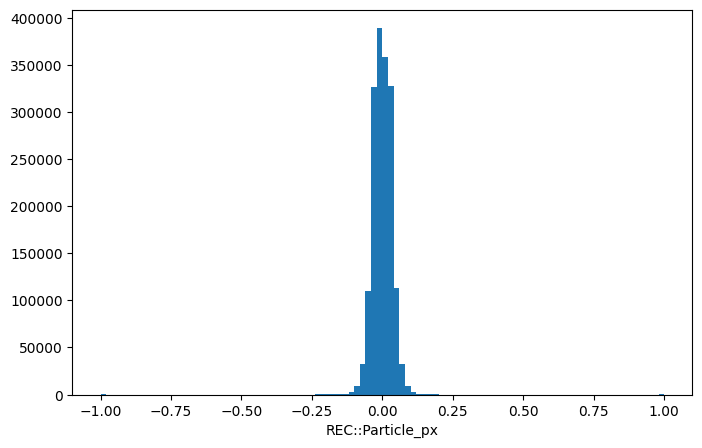

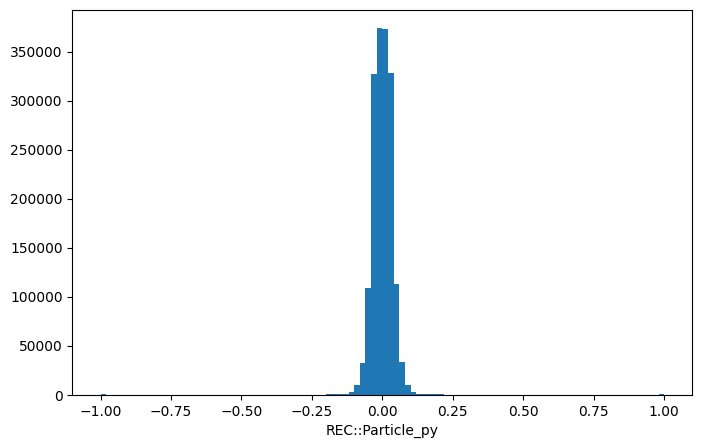

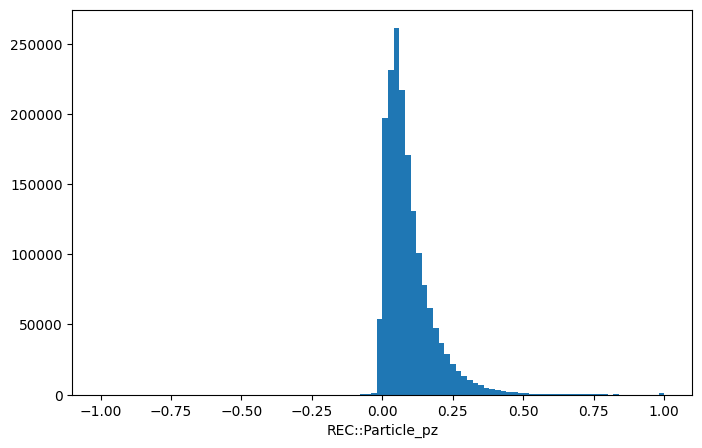

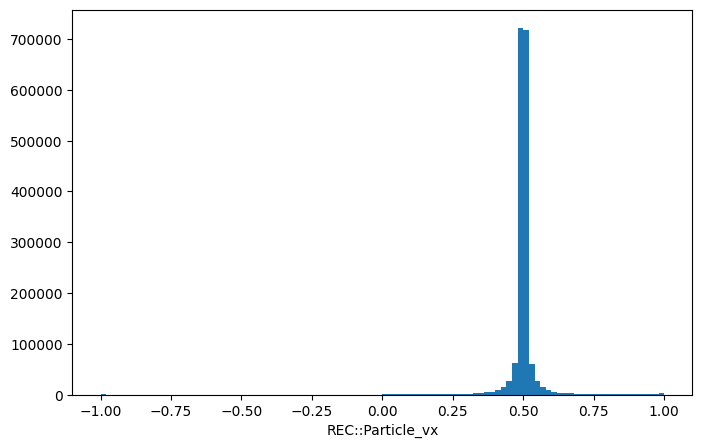

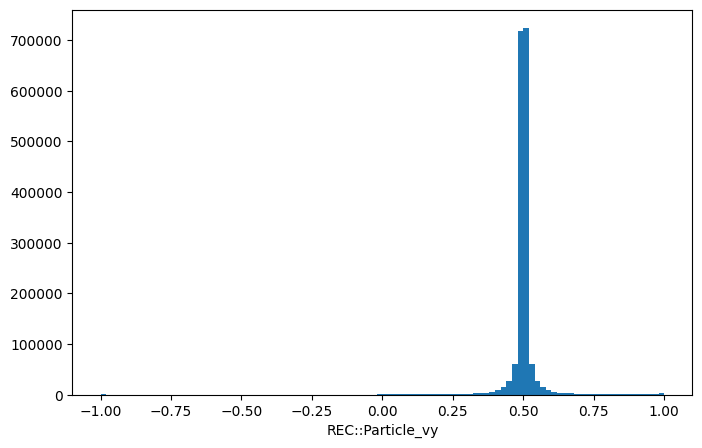

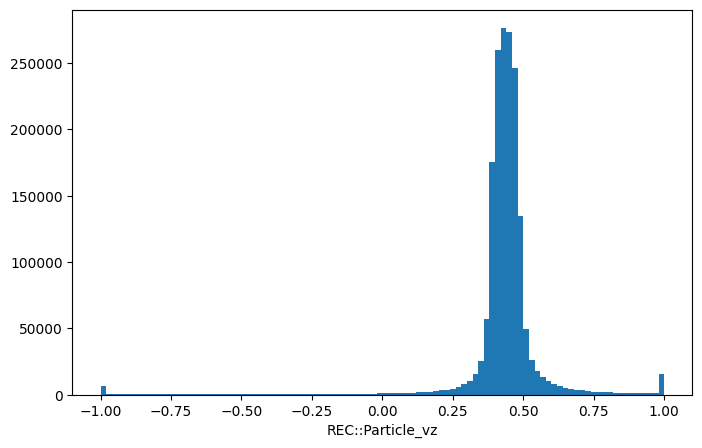

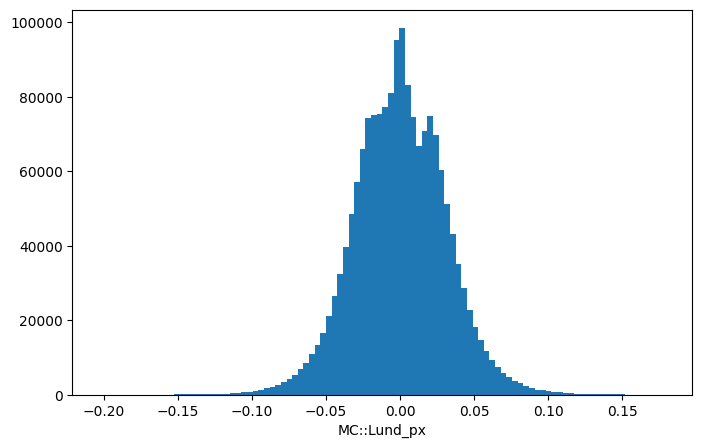

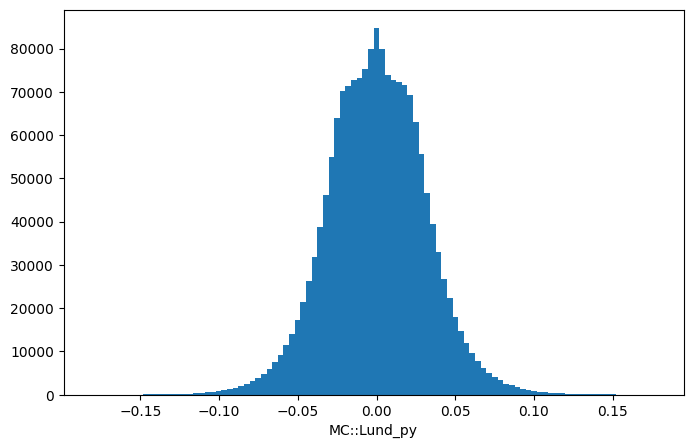

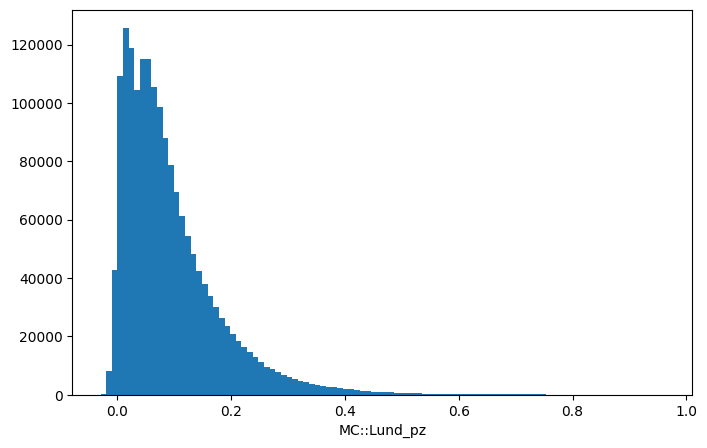

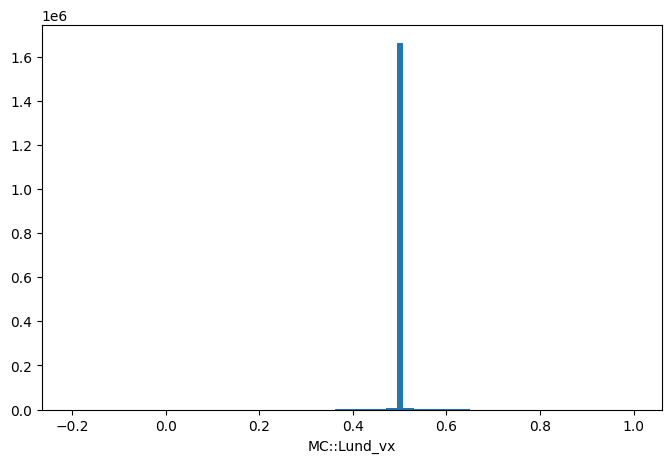

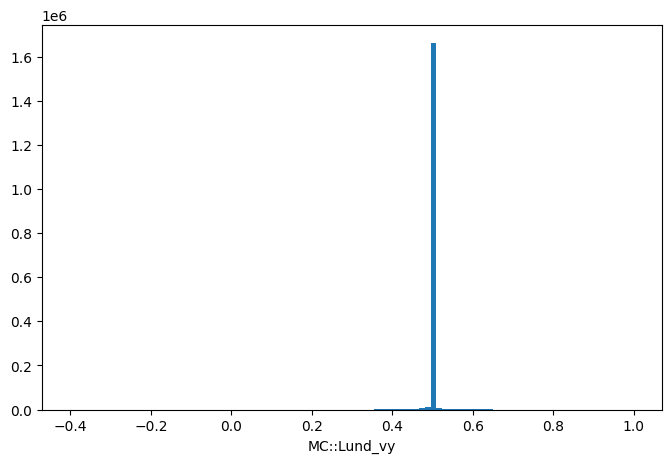

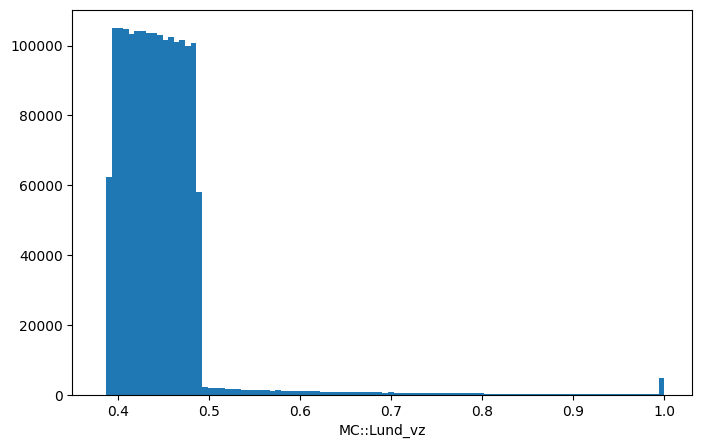

In [177]:
import dask.dataframe as dd
class CustomDataset(Dataset):
    """Custom dataset."""

    def __init__(self, root_dir='.', data_file='data.txt', truth_file='truth.txt', transform=None):
        """
        :param: root_dir (string, optional): Name of root directory containing data_file and truth_file
        :param: data_file (string, optional): Name of data file
        :param: truth_file (string, optional): Name of truth file
        :param: transform (callable, optional): Optional transform to be applied to data entries
        """
        self.root_dir   = root_dir
        self.data_file  = data_file
        self.truth_file = truth_file
        self.transform  = transform
        
        # Load data
        self.data  = dd.read_parquet(os.path.join(root_dir,data_file),dtype=float) #TODO: ADD OPTION FOR USING PANDAS OR DASK
        self.truth = dd.read_parquet(os.path.join(root_dir,truth_file),dtype=float)
        self.data_keys = self.data.columns
        self.truth_keys = self.truth.columns
#         self.data = self.data.iloc[:10, :15]#DEBUGGING!
#         self.truth = self.truth.iloc[:10, :15]#DEBUGGING!
#         print("DEBUGGING: self.data = ",self.data)
#         print("DEBUGGING: self.data[0:10] = \n",self.data[0:10].iloc[12,21,30,111,120,129])
        
        # Convert to torch tensors
        self.data  = self.data.values #NOTE: dtype needs to match weights in NN which are torch.float32 by default.
        self.truth = self.truth.values
        
        print("DEBUGGING: self.data.dtype  = ",self.data.dtype)
        print("DEBUGGING: self.truth.dtype = ",self.truth.dtype)
        
    def to_numpy(self,dtype=float):
        self.data  = np.array(self.data,dtype=dtype)
        self.truth = np.array(self.truth,dtype=dtype)
        
    def to_torch(self,dtype=torch.float32):
        self.data  = torch.Tensor(self.data).to(dtype)
        self.truth = torch.Tensor(self.truth).to(dtype)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = (self.data[idx], self.truth[idx]) #NOTE: IMPORTANT: Need `.iloc[idx]` if self.data, self.truth are pandas dataframes!

        if self.transform:
            sample = self.transform(sample)

        return sample

# Create dataset and split
root_dir = '.'
data_file = 'data.txt'
truth_file = 'truth.txt'
data_file = '/volatile/clas12/users/mfmce/CLAS12_Lambda_resolution_REU_2023_jobs_12_5_23/xyz_full_skim_50nA_OB_job_3313_0.hipo.csv_*.parquet' #NOTE: CANNOT DISTRIBUTE DATALOADER OF PYTORCH SO FAR AS I KNOW BUT CAN USE DASK TO DISTRIBUTE MODEL TRAINING ACROSS DIFFERENT WORKERS WITH THEIR OWN INDIVIDUAL DATALOADERS.
truth_file = '/volatile/clas12/users/mfmce/CLAS12_Lambda_resolution_REU_2023_jobs_12_5_23/ptp_full_skim_50nA_OB_job_3313_0.hipo.csv_*.parquet'
# data_file = 'data_test.csv'
# truth_file = 'truth_test.csv'
def transform(sample):
    
    x, y = sample
    
    # Set indices
    px_index = 0
    py_index = 1
    pz_index = 2
    vx_index = 3
    vy_index = 4
    vz_index = 5
    vt_index = 6
    bt_index = 7
    rec_traj_min_idx = 8
    
    # Calculate additional quantities if needed here before you reassign anything in x
    
    # Reassign values in x
    x[pz_index] /= 10.0
    x[pz_index] /= 10.0
    x[pz_index] /= 10.0
    x[vx_index] -= -25.0
    x[vx_index] /= 50.0
    x[vy_index] -= -25.0
    x[vy_index] /= 50.0
    x[vz_index] -= -25.0
    x[vz_index] /= 50.0
    x[vt_index] -= 124.25
    x[bt_index] -= 1.0
    x[rec_traj_min_idx:] /= 1000.0
    
    # Set indices
    vx_true_index = 0
    vy_true_index = 1
    vz_true_index = 2
    
    # Reassign values in y
    y[vx_true_index] -= -25.0
    y[vx_true_index] /= 50.0
    y[vy_true_index] -= -25.0
    y[vy_true_index] /= 50.0
    y[vz_true_index] -= -25.0
    y[vz_true_index] /= 50.0
    
    # NOTE: Double check data before doing this.
    x = torch.clamp(x,-1,1)
    y = torch.clamp(y,-1,1)
    
    return x, y
    
dataset = CustomDataset(root_dir=root_dir,data_file=data_file,truth_file=truth_file,transform=None)
dataset.data.compute_chunk_sizes() #NOTE: FOR DASK ARRAYS
dataset.truth.compute_chunk_sizes()
dataset.data.persist() #NOTE: THESE ARE ONLY NEEDED FOR CREATING DATALOADERS BELOW.
dataset.truth.persist()
dataset.to_numpy() #NOTE: ONLY NEEDED FOR CREATING PYTORCH DATALOADER BELOW.
dataset.to_torch()

def pretransform(ds):
    
    x, y = ds
    
    # Set indices
    px_index = 0
    py_index = 1
    pz_index = 2
    vx_index = 3
    vy_index = 4
    vz_index = 5
    vt_index = 6
    bt_index = 7
    rec_traj_min_idx = 8
    
    max_linked_entries = 30
    rec_traj_max_entries = 9
    
    rec_traj_layer_idcs = [rec_traj_min_idx+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_detector_idcs = [rec_traj_min_idx+1+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_x_idcs = [rec_traj_min_idx+2+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_y_idcs = [rec_traj_min_idx+3+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_z_idcs = [rec_traj_min_idx+4+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_cx_idcs = [rec_traj_min_idx+5+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_cy_idcs = [rec_traj_min_idx+6+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_cz_idcs = [rec_traj_min_idx+7+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_path_idcs = [rec_traj_min_idx+8+i*rec_traj_max_entries for i in range(max_linked_entries)]
    
    print("DEBUGGING: rec_traj_layer_idcs    = ",rec_traj_layer_idcs)
    print("DEBUGGING: rec_traj_detector_idcs = ",rec_traj_detector_idcs)
    print("DEBUGGING: rec_traj_x_idcs        = ",rec_traj_x_idcs)
    print("DEBUGGING: rec_traj_y_idcs        = ",rec_traj_y_idcs)
    print("DEBUGGING: rec_traj_z_idcs        = ",rec_traj_z_idcs)
    print("DEBUGGING: rec_traj_cx_idcs       = ",rec_traj_cx_idcs)
    print("DEBUGGING: rec_traj_cy_idcs       = ",rec_traj_cy_idcs)
    print("DEBUGGING: rec_traj_cz_idcs       = ",rec_traj_cz_idcs)
    print("DEBUGGING: rec_traj_path_idcs     = ",rec_traj_path_idcs)
    
    
    # Calculate additional quantities if needed here before you reassign anything in x
    
    # Reassign values in x
    x[:,px_index] /= 10.0
    x[:,py_index] /= 10.0
    x[:,pz_index] /= 10.0
    x[:,vx_index] -= -25.0
    x[:,vx_index] /= 50.0
    x[:,vy_index] -= -25.0
    x[:,vy_index] /= 50.0
    x[:,vz_index] -= -25.0
    x[:,vz_index] /= 50.0
    x[:,vt_index] -= 124.25
    x[:,bt_index] -= 1.0
    for idx in rec_traj_layer_idcs:
        x[:,idx] /= 50
    for idx in rec_traj_detector_idcs:
        x[:,idx] /= 50
    for idx in rec_traj_x_idcs:
        x[:,idx] /= 1000.0
    for idx in rec_traj_y_idcs:
        x[:,idx] /= 1000.0
    for idx in rec_traj_z_idcs:
        x[:,idx] /= 1000.0
    for idx in rec_traj_path_idcs:
        x[:,idx] /= 1000.0
    
    # Set indices
    px_true_index = 0
    py_true_index = 1
    pz_true_index = 2
    vx_true_index = 3
    vy_true_index = 4
    vz_true_index = 5
    
    # Reassign values in y
    y[:,px_index] /= 10.0
    y[:,py_index] /= 10.0
    y[:,pz_index] /= 10.0
    y[:,vx_true_index] -= -25.0
    y[:,vx_true_index] /= 50.0
    y[:,vy_true_index] -= -25.0
    y[:,vy_true_index] /= 50.0
    y[:,vz_true_index] -= -25.0
    y[:,vz_true_index] /= 50.0
    
    # NOTE: Double check data before doing this.
    x = torch.clamp(x,-1,1)
    y = torch.clamp(y,-1,1)
    
    return x, y

#NOTE: PRETRANSFORM DATASET FOR NOW
dataset.data, dataset.truth = pretransform((dataset.data,dataset.truth))

print("DEBUGGING: dataset.data.max() = ",dataset.data.max())
print("DEBUGGING: dataset.data.min() = ",dataset.data.min())
print("DEBUGGING: dataset.truth.max() = ",dataset.truth.max())
print("DEBUGGING: dataset.truth.min() = ",dataset.truth.min())
print("DEBUGGING: type(dataset.data) = ",type(dataset.data))
print("DEBUGGING: dataset.data.shape = ",dataset.data.shape)
print("DEBUGGING: len(dataset.data)  = ",len(dataset.data))
# print("DEBUGGING: len(dataset.data.to_numpy())  = ",len(dataset.data.to_numpy()))
train_data, val_data, test_data = random_split(dataset,(0.8,0.1,0.1))
# print(dataset[0])

# df = dd.read_parquet(os.path.join(root_dir,data_file),dtype=np.float64)
# df.compute()

def transform_ds(x):
    
    # Set indices
    px_index = 0
    py_index = 1
    pz_index = 2
    vx_index = 3
    vy_index = 4
    vz_index = 5
    vt_index = 6
    bt_index = 7
    rec_traj_min_idx = 8
    
    # Calculate additional quantities if needed here before you reassign anything in x
    
    # Reassign values in x
    x[:,px_index] /= 10.0
    x[:,py_index] /= 10.0
    x[:,pz_index] /= 10.0
    x[:,vx_index] -= -25.0
    x[:,vx_index] /= 50.0
    x[:,vy_index] -= -25.0
    x[:,vy_index] /= 50.0
    x[:,vz_index] -= -25.0
    x[:,vz_index] /= 50.0
    x[:,vt_index] -= 124.25
    x[:,bt_index] -= 1.0
    x[:,rec_traj_min_idx:] /= 1000.0
    
    x = torch.clamp(x,-1,1)
    
    return x

print("DEBUGGING: len(dataset.data[dataset.data>1])  = ",len(dataset.data[dataset.data>1]))
print("DEBUGGING: len(dataset.data[dataset.data<-1]) = ",len(dataset.data[dataset.data<-1]))
print("DEBUGGING: ",end="\n")
print("DEBUGGING: BEFORE: np.shape(dataset.data) = ",np.shape(dataset.data))
# dataset.data = transform_ds(dataset.data)
print("DEBUGGING: AFTER: np.shape(dataset.data) = ",np.shape(dataset.data))
figs = []
for j in range(np.shape(dataset.data)[1]):
    x = dataset.data[:,j]
    figs.append(plt.figure(figsize=(8,5)))
    plt.hist(x,bins=100,range=(x.min().item(),x.max().item()))
    plt.xlabel(dataset.data_keys[j])
    print("\t j, col, min, mean, max, std = ",
          j,
          dataset.data_keys[j],
          dataset.data[:,j].min(),
          dataset.data[:,j].mean(),
          dataset.data[:,j].max(),
          dataset.data[:,j].std()
         )
    if j > 4: break
        
#NOTE: REPEAT FOR TRUTH INFO
for j in range(np.shape(dataset.truth)[1]):
    x = dataset.truth[:,j]
    figs.append(plt.figure(figsize=(8,5)))
    plt.hist(x,bins=100,range=(x.min().item(),x.max().item()))
    plt.xlabel(dataset.truth_keys[j])
    print("\t j, col, min, mean, max, std = ",
          j,
          dataset.truth_keys[j],
          dataset.truth[:,j].min(),
          dataset.truth[:,j].mean(),
          dataset.truth[:,j].max(),
          dataset.truth[:,j].std()
         )
#     if j > 4: break
    
plt.show()

In [178]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size, drop_last=True) #NOTE: IMPORTANT TO SET DROP_LAST=TRUE IF DATASET IS NOT PERFECTLY MATCHED WITH BATCH_SIZE
val_dataloader   = DataLoader(val_data,   batch_size=batch_size, drop_last=True)
test_dataloader  = DataLoader(test_data,  batch_size=batch_size, drop_last=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    
# print("DEBUGGING: len(test_dataloader.dataset) = ",len(test_dataloader.dataset))
# print("DEBUGGING: test_dataloader.dataset[0][1] = ",test_dataloader.dataset[0][1])
# print("DEBUGGING: len(torch.tensor([el[1] for el in test_dataloader.dataset])) = ",len(torch.tensor([el[1] for el in test_dataloader.dataset])))

Shape of X [N, C, H, W]: torch.Size([64, 278])
Shape of y: torch.Size([64, 6]) torch.float32


In [179]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

1375264
171908
171908


In [180]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        x = self.flatten(x)
#         print("DEBUGGING: in model.forward(): x.dtype = ",x.dtype)
#         print("DEBUGGING: type(model.parameters()) = ",type(model.parameters()))
#         print("DEBUGGING: dtypes of model.parameters() = ",[ el.dtype for el in list(model.parameters())])
        logits = self.linear_relu_stack(x)
        return logits

input_dim  = dataset[0][0].shape[-1]
output_dim = dataset[0][1].shape[-1]
print("DEBUGGING: input_dim = ",input_dim)
print("DEBUGGING: output_dim = ",output_dim)
model = NeuralNetwork(input_dim,output_dim).to(device)#.to(torch.float32) <- default for torch model weights is torch.float32
print(model)

Using cuda device
DEBUGGING: input_dim =  278
DEBUGGING: output_dim =  6
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=278, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=6, bias=True)
  )
)


In [185]:
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR, ReduceLROnPlateau
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)
schedulers = [scheduler2]

In [186]:
optimizer.state_dict()['param_groups'][0]['lr']

0.001

In [187]:
def train(dataloader, model, loss_fn, optimizer, epoch_idx):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
#         print("DEBUGGING: batch = ",batch)
        X, y = X.to(device), y.to(device)
#         print("DEBUGGING: X.dtype = ",X.dtype)
#         print("DEBUGGING: np.array(model.weights)",np.array(model.weights).dtype)
        if torch.any(torch.isnan(X)):
            print("FOUND NAN IN INPUT")
        if torch.any(torch.isnan(y)):
            print("FOUND NAN IN LABEL")
        if X.shape[0]!=batch_size:
            print("DEBUGGING: X.shape = ",X.shape)
            print("DEBUGGING: y.shape = ",y.shape)
#         print("DEBUGGING: X.dtype = ",X.dtype)
#         print("DEBUGGING: y.dtype = ",y.dtype)
#         print("DEBUGGING: list(model.parameters())[0]       = ",list(model.parameters())[0])
#         print("DEBUGGING: list(model.parameters())[0].dtype = ",list(model.parameters())[0].dtype)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"\rEpoch {epoch_idx}: Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]",end="")
            losses.append(loss)
            
    mean_loss = np.mean(losses)
    print(f"\rEpoch {epoch_idx}: Training loss: {mean_loss:>7f}  [{current:>5d}/{size:>5d}]",end="\n")
    
    lr = optimizer.state_dict()['param_groups'][0]['lr']
    
    for s in schedulers:
        s.step()
    return mean_loss, lr

In [188]:
def val(dataloader, model, loss_fn, epoch_idx):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    fractional_diffs = torch.zeros(output_dim).to(device)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
#             print("DEBUGGING: X.shape = ",X.shape)
#             print("DEBUGGING: y.shape = ",y.shape)
#             print("DEBUGGING: X.dtype = ",X.dtype)
#             print("DEBUGGING: y.dtype = ",y.dtype)
#             print("DEBUGGING: list(model.parameters())[0]       = ",list(model.parameters())[0])
#             print("DEBUGGING: list(model.parameters())[0].dtype = ",list(model.parameters())[0].dtype)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
#             correct = torch.add(fractional_diffs,torch.divide((pred - y),y))
    test_loss /= num_batches
#     correct /= size
    print(f"Epoch {epoch_idx}: Validation loss: {test_loss:>8f}")
    
    return test_loss

In [189]:
epochs = 40
train_losses = []
val_losses = []
lrs = []
for epoch_idx in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
    train_loss, lr = train(train_dataloader, model, loss_fn, optimizer, epoch_idx)
    val_loss = val(val_dataloader, model, loss_fn, epoch_idx)
#     print("DEBUGGING: type(train_loss) = ",type(train_loss))
#     print("DEBUGGING: type(val_loss) = ",type(val_loss))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    lrs.append(lr)
print("Done!")

Epoch 0: Training loss: 0.001359  [1369664/1375264]
Epoch 0: Validation loss: 0.000794
Epoch 1: Training loss: 0.000749  [1369664/1375264]
Epoch 1: Validation loss: 0.000738
Epoch 2: Training loss: 0.000717  [1369664/1375264]
Epoch 2: Validation loss: 0.000702
Epoch 3: Training loss: 0.000701  [1369664/1375264]
Epoch 3: Validation loss: 0.000711
Epoch 4: Training loss: 0.000695  [1369664/1375264]
Epoch 4: Validation loss: 0.000689
Epoch 5: Training loss: 0.000690  [1369664/1375264]
Epoch 5: Validation loss: 0.000681
Epoch 6: Training loss: 0.000677  [1369664/1375264]
Epoch 6: Validation loss: 0.000685
Epoch 7: Training loss: 0.000681  [1369664/1375264]
Epoch 7: Validation loss: 0.000680
Epoch 8: Training loss: 0.000672  [1369664/1375264]
Epoch 8: Validation loss: 0.000668
Epoch 9: Training loss: 0.000671  [1369664/1375264]
Epoch 9: Validation loss: 0.000676
Epoch 10: Training loss: 0.000630  [1369664/1375264]
Epoch 10: Validation loss: 0.000637
Epoch 11: Training loss: 0.000625  [13696

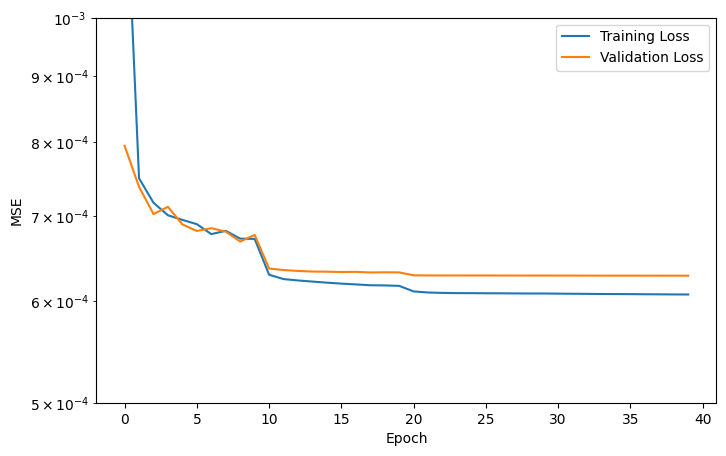

In [190]:
f = plt.figure(figsize=(8,5))
plt.semilogy([i for i in range(epochs)],train_losses,color='tab:blue',label='Training Loss')
plt.semilogy([i for i in range(epochs)],val_losses,color='tab:orange',label='Validation Loss')
plt.ylim((5e-4,1e-3))
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='best')

DEBUGGING: size =  171908
DEBUGGING: num_batches =  2686
Test Error: 
 Avg loss: 0.000616 

DEBUGGING: inputs.shape =  torch.Size([171904, 278])
DEBUGGING: correct.shape =  torch.Size([171904, 6])
DEBUGGING: preds.shape =  torch.Size([171904, 6])
DEBUGGING: tests.shape =  torch.Size([171904, 6])

DEBUGGING: correct.min() =  -0.7176615595817566
DEBUGGING: preds.min() =  -0.1683703362941742
DEBUGGING: tests.min() =  -0.159170001745224

DEBUGGING: correct.max() =  0.6760586500167847
DEBUGGING: preds.max() =  1.141606092453003
DEBUGGING: tests.max() =  1.0

DEBUGGING: correct.mean() =  -8.913276542443782e-05
DEBUGGING: preds.mean() =  0.2565919756889343
DEBUGGING: tests.mean() =  0.2566811144351959

DEBUGGING: correct.std() =  0.024809792637825012
DEBUGGING: preds.std() =  0.23174868524074554
DEBUGGING: tests.std() =  0.233061745762825
DEBUGGING: target label =  MC::Lund_px
DEBUGGING: mean Delta   =  tensor(-0.0009)
DEBUGGING: std Delta    =  tensor(0.1415)
DEBUGGING: mean orig Delta   =  

/tmp/ipykernel_64142/2055944619.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f0 = plt.figure(figsize=figsize)


DEBUGGING: target label =  MC::Lund_vz
DEBUGGING: mean Delta   =  tensor(-0.0014)
DEBUGGING: std Delta    =  tensor(0.3779)
DEBUGGING: mean orig Delta   =  tensor(-0.1200)
DEBUGGING: std orig Delta    =  tensor(1.5122)


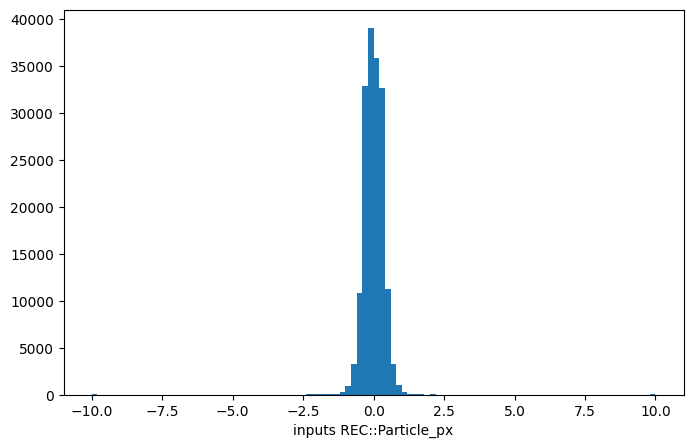

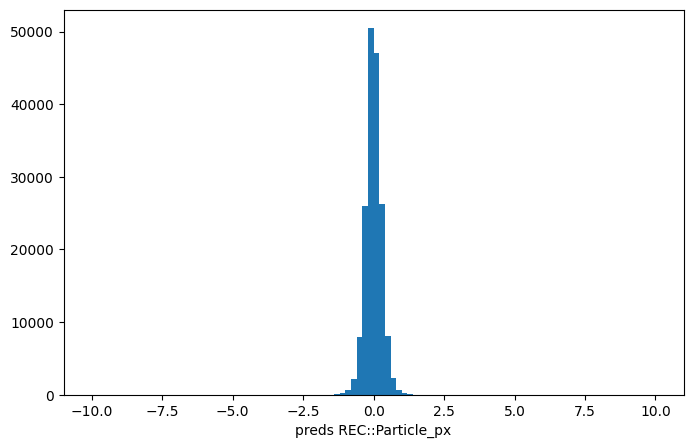

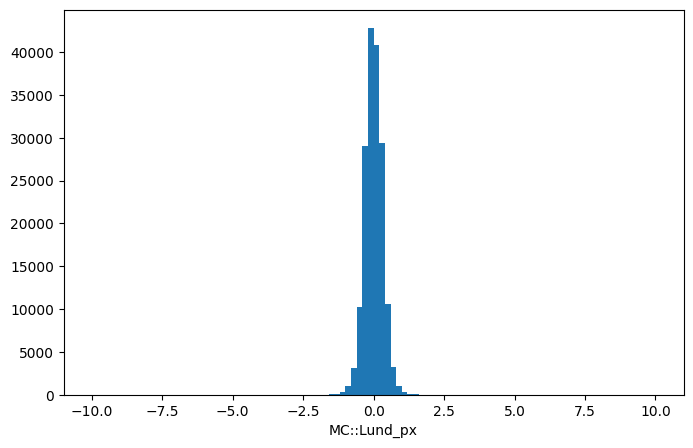

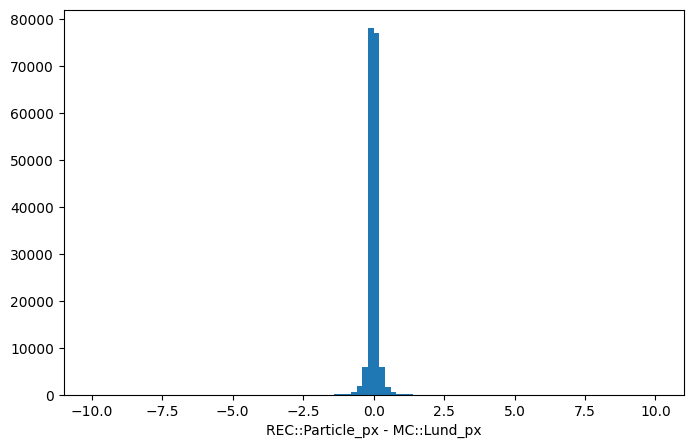

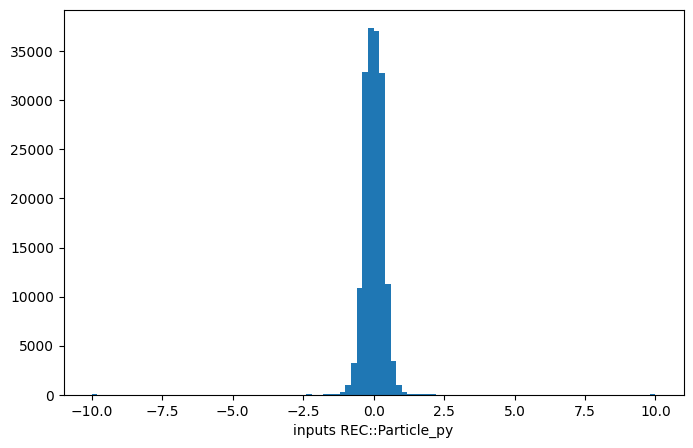

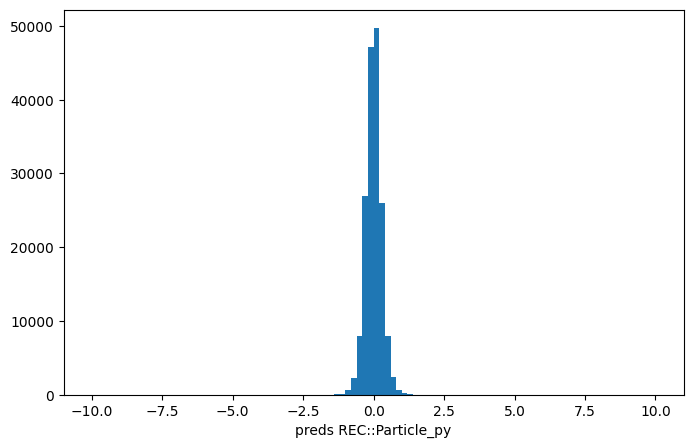

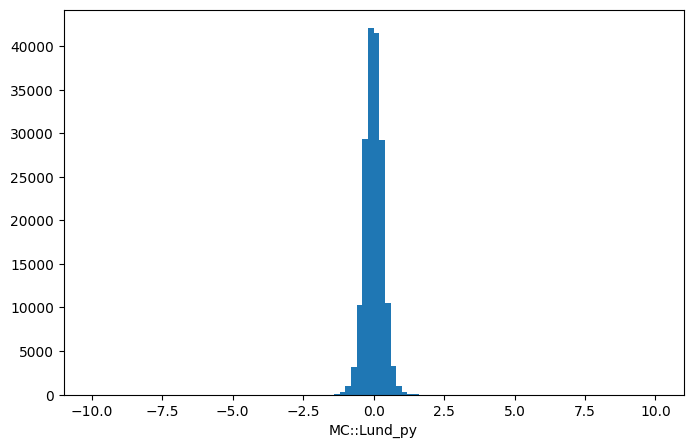

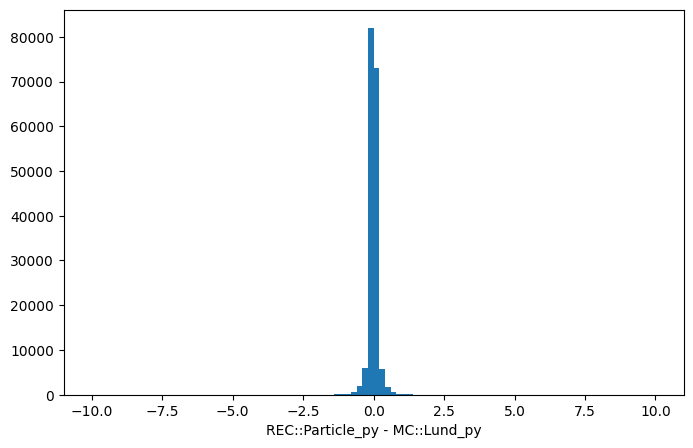

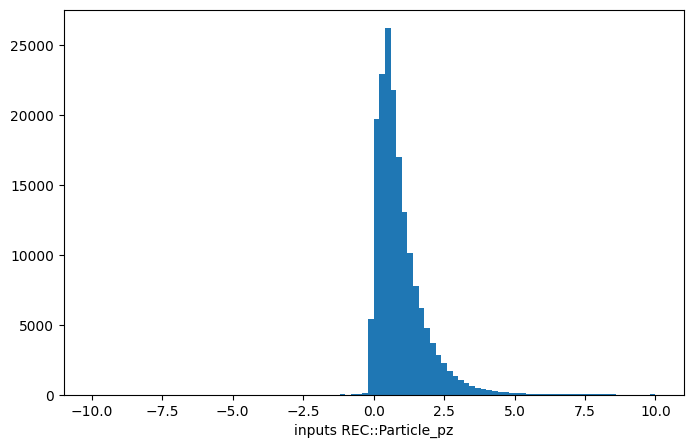

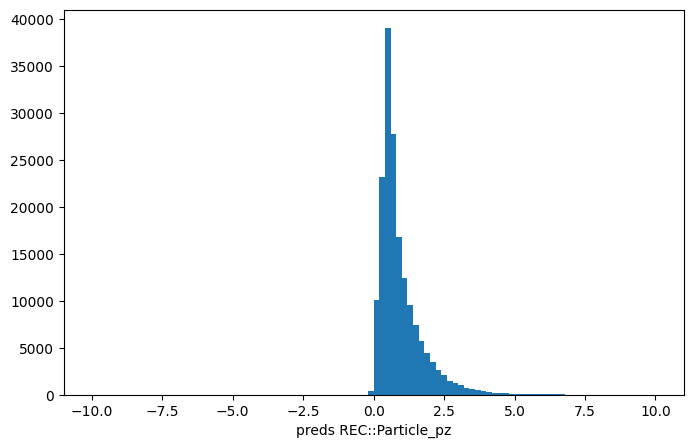

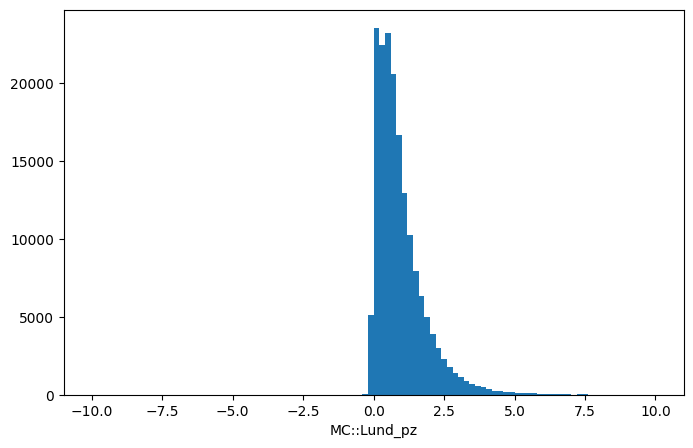

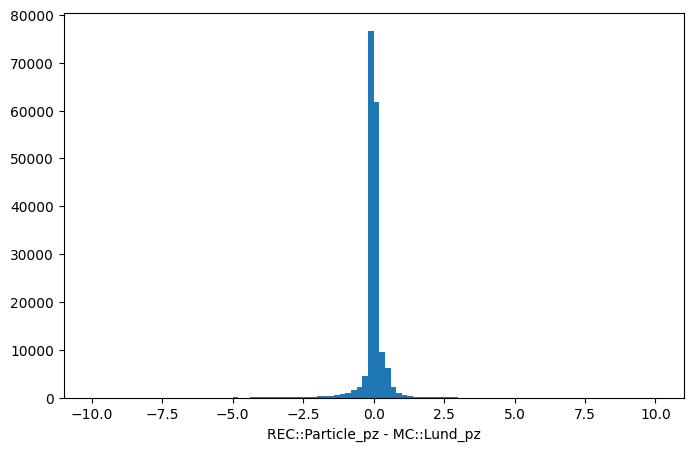

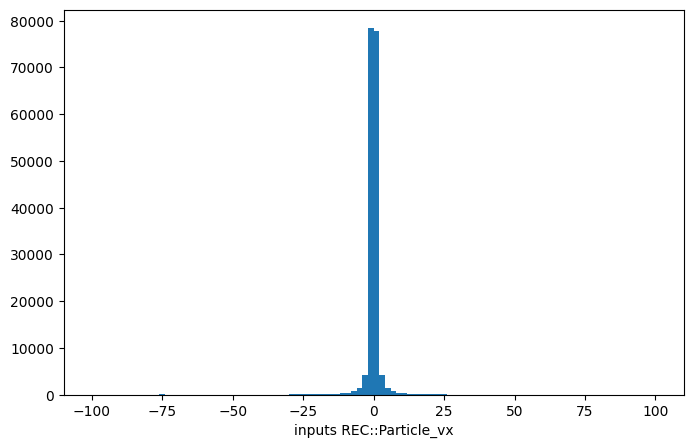

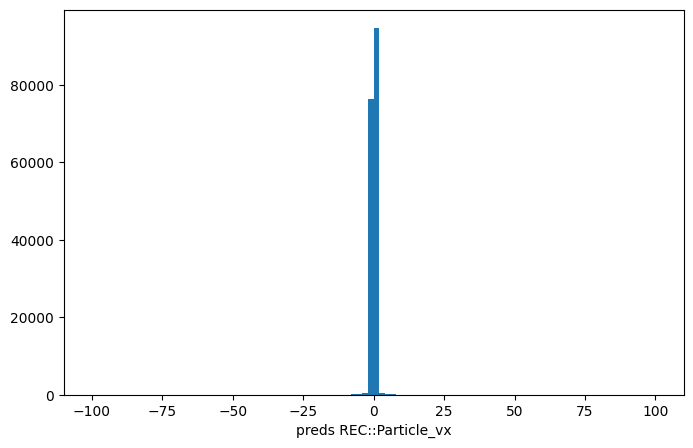

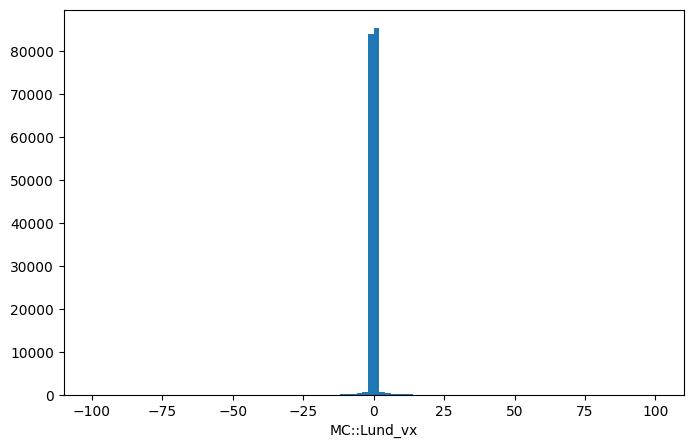

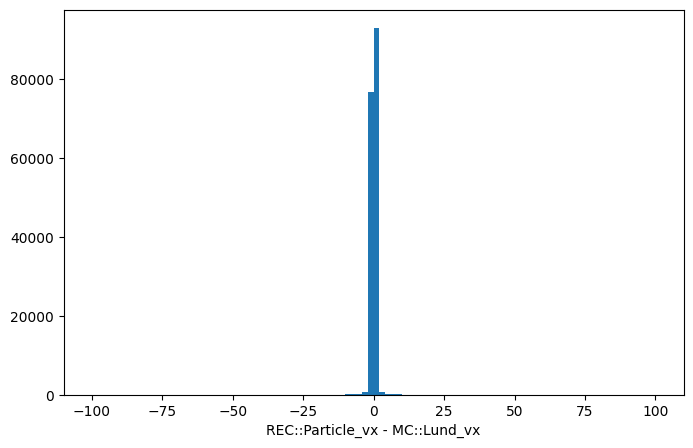

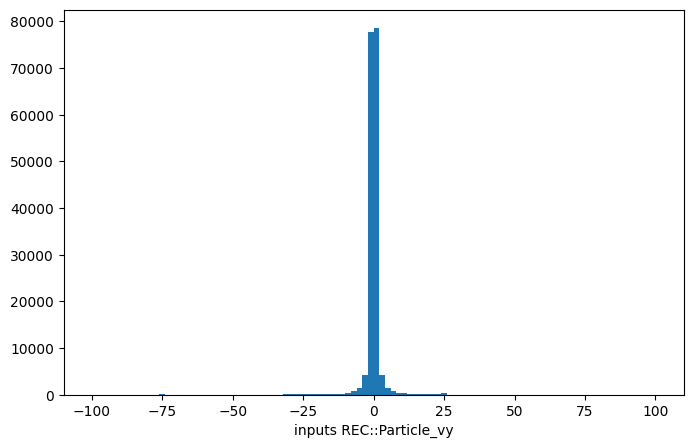

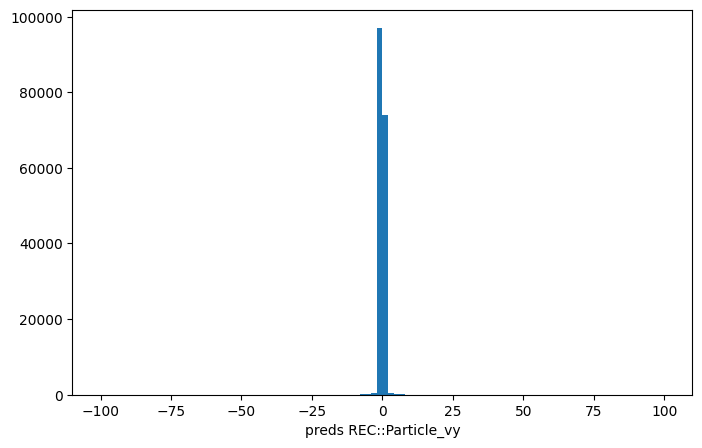

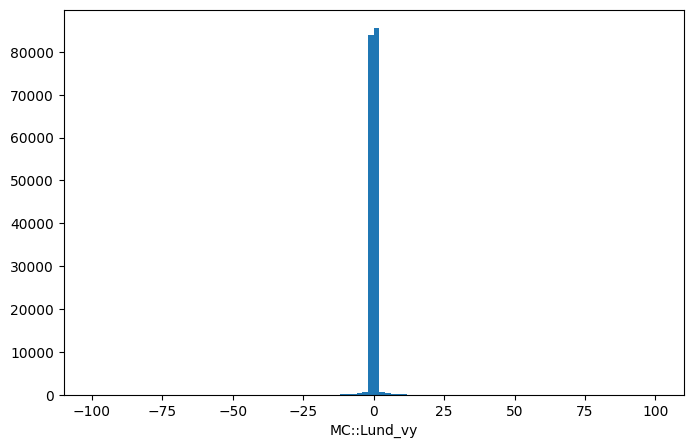

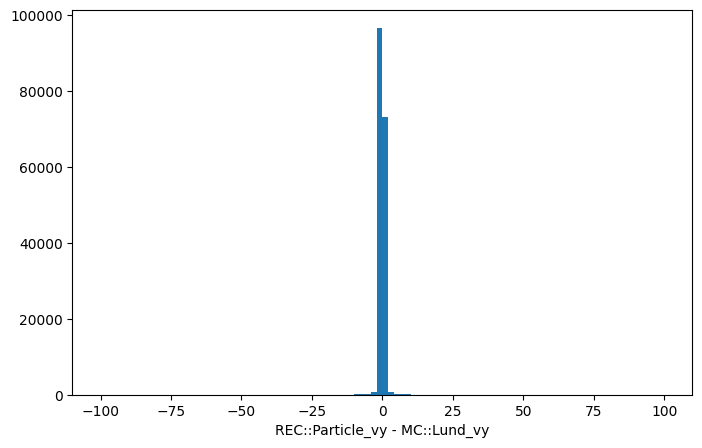

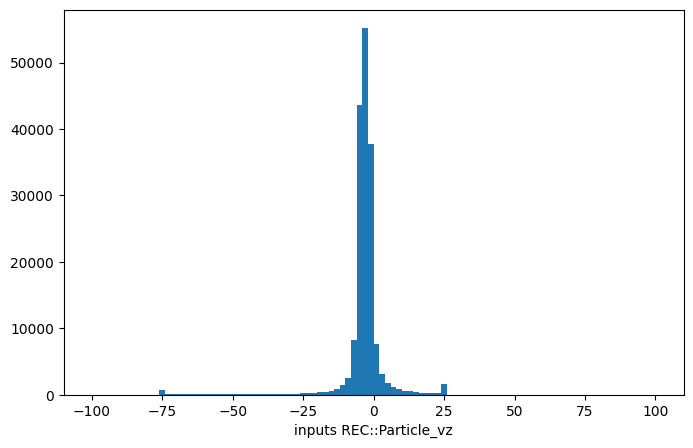

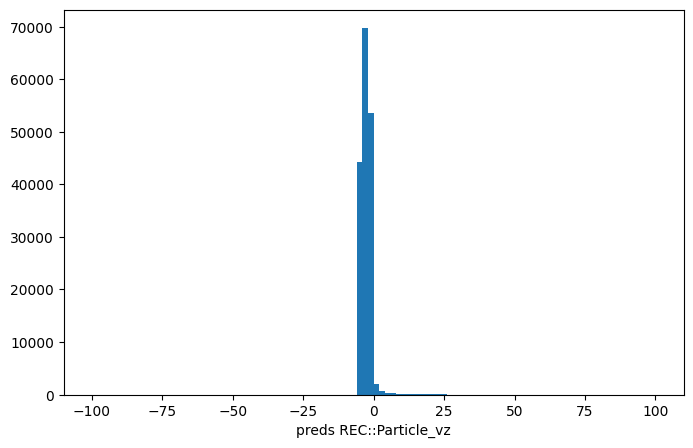

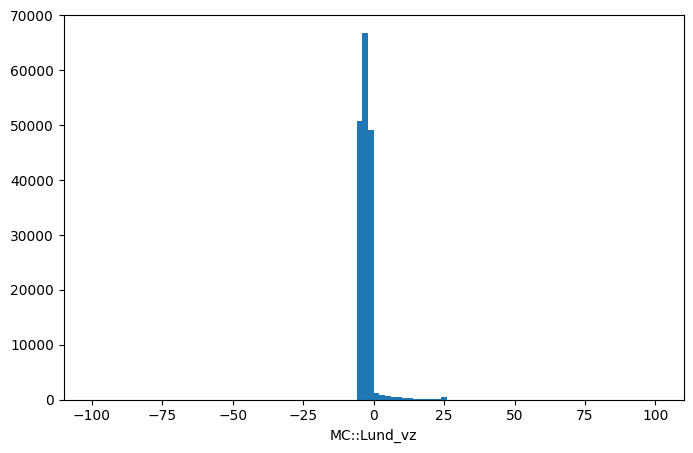

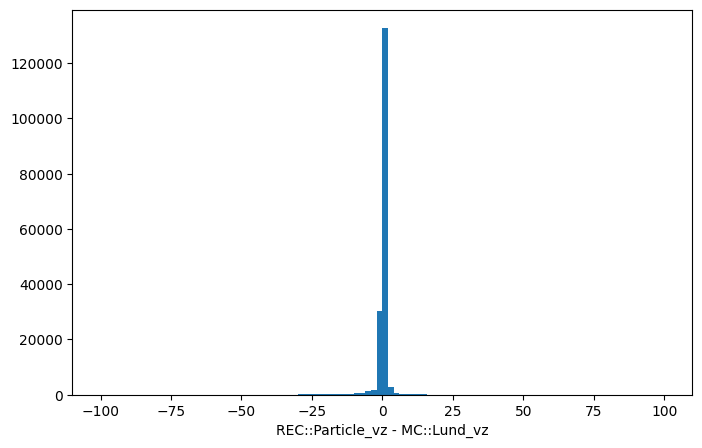

In [191]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    print("DEBUGGING: size = ",size)
    num_batches = len(dataloader)
    print("DEBUGGING: num_batches = ",num_batches)
    model.eval()
    test_loss = 0
    inputs = None
    preds = None
    tests = None
    correct = None
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
#             print("DEBUGGING: X.shape = ",X.shape)
#             print("DEBUGGING: y.shape = ",y.shape)
#             print("DEBUGGING: X.dtype = ",X.dtype)
#             print("DEBUGGING: y.dtype = ",y.dtype)
#             print("DEBUGGING: list(model.parameters())[0]       = ",list(model.parameters())[0])
#             print("DEBUGGING: list(model.parameters())[0].dtype = ",list(model.parameters())[0].dtype)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            inputs = torch.concatenate((inputs,X),axis=0) if inputs is not None else X
            preds = torch.concatenate((preds,pred),axis=0) if preds is not None else pred
            tests = torch.concatenate((tests,y),axis=0) if tests is not None else y
            correct = torch.concatenate((correct,pred - y),axis=0) if correct is not None else pred - y
    test_loss /= num_batches
#     correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    
    # Copy to CPU
    inputs = inputs.cpu()
    correct = correct.cpu()
    preds = preds.cpu()
    tests = tests.cpu()
    
    print("DEBUGGING: inputs.shape = ",inputs.shape)
    print("DEBUGGING: correct.shape = ",correct.shape)
    print("DEBUGGING: preds.shape = ",preds.shape)
    print("DEBUGGING: tests.shape = ",tests.shape)
    print()
    print("DEBUGGING: correct.min() = ",correct.min().item())
    print("DEBUGGING: preds.min() = ",preds.min().item())
    print("DEBUGGING: tests.min() = ",tests.min().item())
    print()
    print("DEBUGGING: correct.max() = ",correct.max().item())
    print("DEBUGGING: preds.max() = ",preds.max().item())
    print("DEBUGGING: tests.max() = ",tests.max().item())
    print()
    print("DEBUGGING: correct.mean() = ",correct.mean().item())
    print("DEBUGGING: preds.mean() = ",preds.mean().item())
    print("DEBUGGING: tests.mean() = ",tests.mean().item())
    print()
    print("DEBUGGING: correct.std() = ",correct.std().item())
    print("DEBUGGING: preds.std() = ",preds.std().item())
    print("DEBUGGING: tests.std() = ",tests.std().item())
    
    low_high = (-10,10)
    
    # Plot differences between test and prediction
    figs = []
    for j in range(0,3):
        figsize = (8,5)
        f0 = plt.figure(figsize=figsize)
        a0 = plt.hist((inputs[:,j]*10),bins=100,range=low_high)
        plt.xlabel('inputs '+dataset.data_keys[j])
        
        figsize = (8,5)
        f1 = plt.figure(figsize=figsize)
        a1 = plt.hist((preds[:,j]*10),bins=100,range=low_high)
        plt.xlabel('preds '+dataset.data_keys[j])

        figsize = (8,5)
        f2 = plt.figure(figsize=figsize)
        a2 = plt.hist((tests[:,j]*10),bins=100,range=low_high)
        plt.xlabel(dataset.truth_keys[j])

        figsize = (8,5)
        f3 = plt.figure(figsize=figsize)
        a3 = plt.hist((correct[:,j]*10),bins=100,range=low_high)
        plt.xlabel(dataset.data_keys[j]+' - '+dataset.truth_keys[j])
        
        # Print stuff
        print("DEBUGGING: target label = ",dataset.truth_keys[j])
        print("DEBUGGING: mean Delta   = ",correct[:,j].mean()*10)
        print("DEBUGGING: std Delta    = ",correct[:,j].std()*10)
        
        # Get original diffs
        original_deltas = np.subtract(inputs[:,j],tests[:,j])
        print("DEBUGGING: mean orig Delta   = ",original_deltas.mean()*10)
        print("DEBUGGING: std orig Delta    = ",original_deltas.std()*10)
        
        figs.extend([f0,f1,f2,f3])
    
    low_high = (-100,100)
    
    # Plot differences between test and prediction
    for j in range(3,6):
        figsize = (8,5)
        f0 = plt.figure(figsize=figsize)
        a0 = plt.hist((inputs[:,j]*50)-25,bins=100,range=low_high)
        plt.xlabel('inputs '+dataset.data_keys[j])
        
        figsize = (8,5)
        f1 = plt.figure(figsize=figsize)
        a1 = plt.hist((preds[:,j]*50)-25,bins=100,range=low_high)
        plt.xlabel('preds '+dataset.data_keys[j])

        figsize = (8,5)
        f2 = plt.figure(figsize=figsize)
        a2 = plt.hist((tests[:,j]*50)-25,bins=100,range=low_high)
        plt.xlabel(dataset.truth_keys[j])

        figsize = (8,5)
        f3 = plt.figure(figsize=figsize)
        a3 = plt.hist((correct[:,j]*50),bins=100,range=low_high)
        plt.xlabel(dataset.data_keys[j]+' - '+dataset.truth_keys[j])
        
        # Print stuff
        print("DEBUGGING: target label = ",dataset.truth_keys[j])
        print("DEBUGGING: mean Delta   = ",correct[:,j].mean()*10)
        print("DEBUGGING: std Delta    = ",correct[:,j].std()*10)
        
        # Get original diffs
        original_deltas = np.subtract(inputs[:,j],tests[:,j])
        print("DEBUGGING: mean orig Delta   = ",original_deltas.mean()*10)
        print("DEBUGGING: std orig Delta    = ",original_deltas.std()*10)
        
        figs.extend([f0,f1,f2,f3])
        
    plt.show()
    
test(test_dataloader, model, loss_fn)

In [58]:
print(len(train_dataloader))

4908


In [5]:
torch.float

torch.float32